In [1]:
import pandas as pd
import numpy as np
import math
import datetime
from matplotlib import pyplot as plt
import seaborn as sns
from time import sleep as fallasleep
import os, sys

In [2]:
import krakenex
from pykrakenapi import KrakenAPI

In [3]:
color_box = ['#1f77b4','#ff7f0e','#2ca02c','#d62728',
             '#9467bd','#8c564b','#e377c2','#7f7f7f',
             '#bcdb22','#17becf']

In [4]:
api = krakenex.API()
k = KrakenAPI(api)
coins = ["ETH", "BTC", "XRP", "ADA", "DOT"]
gapmin= 1440
coins = [coin+"USD" for coin in coins]
df = {}
colormapper = {}
for _,coin in enumerate(coins):
    data, last = k.get_ohlc_data(coin, interval = gapmin, ascending = True)
    df[coin]=data.drop(['time', 'count'], axis=1)
    colormapper[coin] = color_box[_]
    fallasleep(1)


In [5]:
df_close = pd.DataFrame(columns=coins)
for coin in coins:
    df_close[coin] = df[coin]['close']

In [6]:
df_close.isna().sum()

ETHUSD      0
BTCUSD      0
XRPUSD      0
ADAUSD      0
DOTUSD    270
dtype: int64

In [7]:
df_close = df_close.dropna()
df_close.isna().sum()

ETHUSD    0
BTCUSD    0
XRPUSD    0
ADAUSD    0
DOTUSD    0
dtype: int64

In [8]:
df_close.head(3)

,ETHUSD,BTCUSD,XRPUSD,ADAUSD,DOTUSD
dtime,,,,,
2020-08-18,422.62,11957.0,0.30292,0.137218,3.1099
2020-08-19,407.57,11757.4,0.28992,0.129678,2.9175
2020-08-20,416.20,11864.6,0.29246,0.134305,2.9090


In [9]:
df_close_diff = df_close.apply(np.log).diff().dropna()
df_close_diff.head(3)

,ETHUSD,BTCUSD,XRPUSD,ADAUSD,DOTUSD
dtime,,,,,
2020-08-19,-0.036261,-0.016834,-0.043864,-0.056516,-0.063863
2020-08-20,0.020953,0.009076,0.008723,0.035059,-0.002918
2020-08-21,-0.070599,-0.029240,-0.046364,-0.087043,0.056341


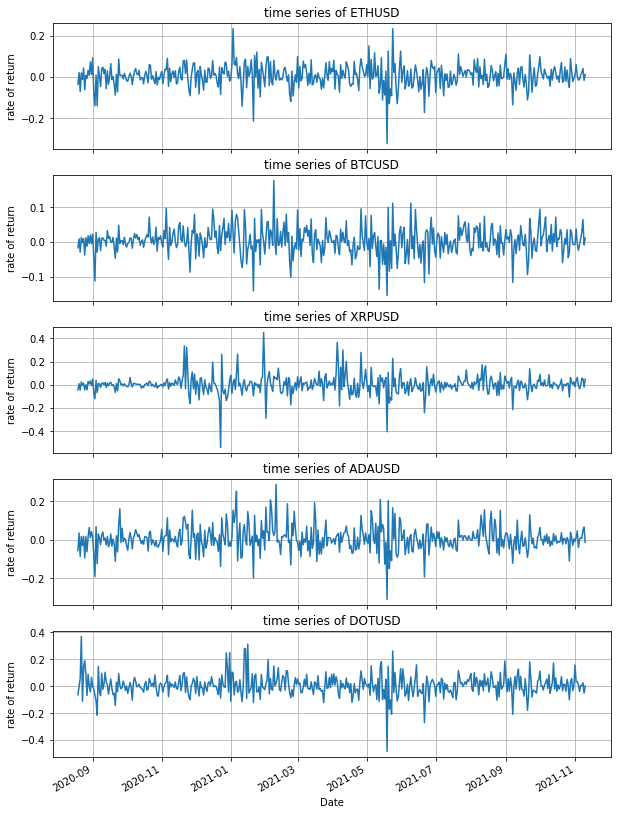

In [10]:
# fig = plt.figure(figsize=(8,6))
fig, ax = plt.subplots(len(df_close_diff.columns),1,figsize=(10,15))
for _,col in enumerate(df_close_diff):
    ax[_].plot(df_close_diff.index, df_close_diff[col].values)
    ax[_].set_title(f"time series of {col}")
    ax[_].set_ylabel("rate of return")
    ax[_].set_xlabel("Date")
    ax[_].grid()
fig.autofmt_xdate()
plt.show()

### Mean-Variance Optimization (with cardinality constraint) - BUY/SELL
$$
\begin{aligned}
& \underset{x}{\text{minimize}} & & \frac{1}{2} \lambda x^TQx - (1 - \lambda) r^Tx\\
        &\text{subject to}&& \mathbf{1}^Tx = k\\
        &&& x \in \{0,1\}\\
        &&& \lambda \in [0,1]\\
\end{aligned}
$$

In [11]:
Q = df_close_diff.cov().values
r = df_close_diff.mean().values

## Using Gurobi

In [12]:
from gurobipy import *

In [13]:
def obj_val(x):
    return 0.5 * lam * (x @ Q @ x) - (1 - lam) * (r @ x)

In [14]:
m = Model("MVO")
x = {}
n = len(Q)
lam = 0.5
k = 2
x = m.addMVar(shape=n,vtype=GRB.BINARY, name=coins)
obj = 0.5 * lam * (x @ Q @ x) - (1 - lam) * (r @ x)
m.addConstr(x.sum()==k)
m.setObjective(obj, GRB.MINIMIZE)
m.optimize()

selected = []
for v in m.getVars():
    if v.x == 1:
        selected.append(v.VarName)
print(selected)

Restricted license - for non-production use only - expires 2022-01-13
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 5 columns and 5 nonzeros
Model fingerprint: 0x7b609d21
Model has 15 quadratic objective terms
Variable types: 0 continuous, 5 integer (5 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e-03, 3e-03]
  QObjective range [8e-04, 3e-03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+00, 2e+00]
Found heuristic solution: objective -0.0026521
Presolve time: 0.00s
Presolved: 11 rows, 15 columns, 35 nonzeros
Variable types: 0 continuous, 15 integer (15 binary)

Root relaxation: objective -3.551510e-03, 4 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   -0.00355    0    4   -0.00

In [15]:
obj_val([0,1,0,1,0])

-0.0027839508440305367

## Using Qiskit

In [16]:
from qiskit import Aer
from qiskit.algorithms import VQE, QAOA
from qiskit.algorithms.optimizers import COBYLA
from qiskit.circuit.library import TwoLocal
from qiskit.utils import QuantumInstance
from qiskit_finance.applications.optimization import PortfolioOptimization
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_optimization.converters import QuadraticProgramToQubo
from qiskit.utils import algorithm_globals

### Mean-Variance Optimization (with cardinality constraint), Unconstrained - BUY/SELL
$$
\begin{aligned}
& \underset{x}{\text{minimize}} & & \frac{1}{2} \lambda x^TQx - (1 - \lambda) r^Tx +  P \cdot (\mathbf{1}^Tx - k)^T \cdot (\mathbf{1}^Tx - k)\\
        &&& x \in \{0,1\}\\
\end{aligned}
$$

In [17]:
portfolio = PortfolioOptimization(expected_returns=(1-lam)*r, covariances=0.5*Q,
                                  risk_factor=lam, budget=k)
qp = portfolio.to_quadratic_program()
seed = 6969

### QAOA

In [24]:
def selection_to_picks(num_assets, selection):
    purchase = []
    for i in range(num_assets):
        if selection[i] == 1:
            purchase.append(coins[i])
    return purchase

def index_to_selection(i, n):
    s = "{0:b}".format(i).rjust(n)
    x = np.array([1 if s[i]=='1' else 0 for i in reversed(range(n))])
    return x

def print_result(result):
    selection = result.x
    value = result.fval
    print('Optimal: selection {}, value {:.6f}'.format(selection, value))
    
    eigenstate = result.min_eigen_solver_result.eigenstate
    eigenvector = eigenstate if isinstance(eigenstate, np.ndarray) else eigenstate.to_matrix()
    probabilities = np.abs(eigenvector)**2
    i_sorted = reversed(np.argsort(probabilities))
    print('\n----------------- Full result ---------------------')
    print('selection\tvalue\t\tprobability')
    print('---------------------------------------------------')
    states, values, probs = [], [], []
    for i in i_sorted:
        x = index_to_selection(i, n)
        value = QuadraticProgramToQubo().convert(qp).objective.evaluate(x)
        #value = portfolio.to_quadratic_program().objective.evaluate(x)
        probability = probabilities[i]
        print('%10s\t%.6f\t\t%.6f' %(x, value, probability))
        states.append(''.join(str(i) for i in x))
        values.append(value)
        probs.append(probability)
    return selection, states, values, probs

In [25]:
algorithm_globals.random_seed = seed
backend = Aer.get_backend('statevector_simulator')

cobyla = COBYLA()
cobyla.set_options(maxiter=250)
quantum_instance = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed)
qaoa_mes = QAOA(optimizer=cobyla, reps=3, quantum_instance=quantum_instance)
qaoa = MinimumEigenOptimizer(qaoa_mes)
result = qaoa.solve(qp)

selection, state, values, probabilities = print_result(result)
print(selection_to_picks(n, selection))

Optimal: selection [0. 1. 0. 1. 0.], value -0.002784

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
[0 0 1 0 1]	-0.000060		0.099993
[1 0 1 0 0]	-0.000658		0.099724
[0 0 1 1 0]	-0.000576		0.099687
[0 1 1 0 0]	-0.000636		0.099571
[1 0 0 0 1]	-0.002087		0.099158
[0 0 0 1 1]	-0.002091		0.099157
[0 1 0 0 1]	-0.002190		0.099058
[1 0 0 1 0]	-0.002761		0.098920
[0 1 0 1 0]	-0.002784		0.098787
[1 1 0 0 0]	-0.002652		0.098734
[1 1 1 1 1]	9.271476		0.002085
[0 1 0 0 0]	1.028114		0.000574
[1 0 0 0 0]	1.027692		0.000543
[0 0 0 1 0]	1.027626		0.000540
[0 0 1 0 0]	1.029695		0.000539
[0 0 0 0 1]	1.028047		0.000529
[0 0 0 0 0]	4.118582		0.000464
[1 1 0 1 1]	4.118224		0.000280
[1 0 1 1 1]	4.121394		0.000279
[0 1 1 1 1]	4.120446		0.000271
[1 1 1 0 1]	4.120368		0.000270
[1 1 1 1 0]	4.119424		0.000269
[0 0 1 1 1]	1.030488		0.000061
[1 0 1 0 1]	1.030344		0.000060
[0 1 1 0 1]	1.029841		0.000059
[1 0 1 1 0]	1.029574		0.0000

/home/ape/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


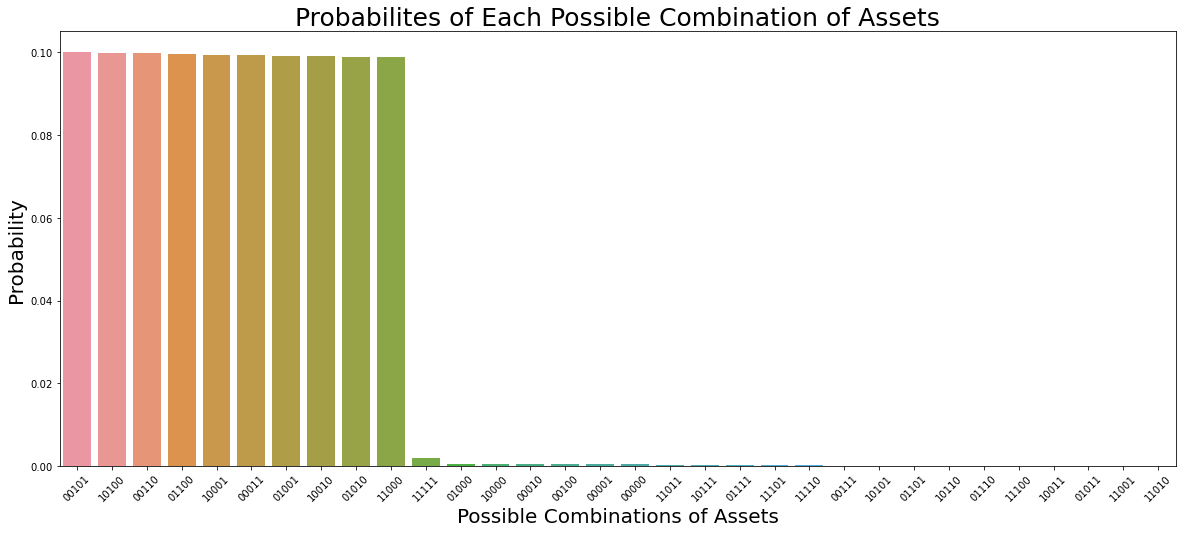

In [26]:
fig, ax = plt.subplots(figsize=(20, 8))
optimized_value = sns.barplot(state, probabilities)
for item in optimized_value.get_xticklabels():
    item.set_rotation(45)
plt.title("Probabilites of Each Possible Combination of Assets", fontsize=25) # Probability of Max Return at given risk level
plt.xlabel('Possible Combinations of Assets',fontsize =20)
plt.ylabel('Probability',fontsize = 20)
plt.show()

### VQE

In [27]:
algorithm_globals.random_seed = seed
backend = Aer.get_backend('statevector_simulator')

cobyla = COBYLA()
cobyla.set_options(maxiter=500)
ry = TwoLocal(n, 'ry', 'cz', reps=3, entanglement='full')
quantum_instance = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed)
vqe_mes = VQE(ry, optimizer=cobyla, quantum_instance=quantum_instance)
vqe = MinimumEigenOptimizer(vqe_mes)
result = vqe.solve(qp)

selection, state, values, probabilities = print_result(result)
print(selection_to_picks(n, selection))

Optimal: selection [0. 1. 0. 1. 0.], value -0.002784

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
[1 0 0 0 1]	-0.002087		0.859279
[0 0 1 0 1]	-0.000060		0.061931
[0 0 0 1 1]	-0.002091		0.055508
[0 1 0 0 1]	-0.002190		0.017643
[0 0 1 1 1]	1.030488		0.002259
[0 1 0 1 1]	1.027731		0.001076
[0 1 1 0 1]	1.029841		0.000982
[1 1 0 0 1]	1.027801		0.000495
[1 0 1 0 1]	1.030344		0.000312
[0 0 0 1 0]	1.027626		0.000110
[1 0 0 1 1]	1.028279		0.000074
[0 1 0 1 0]	-0.002784		0.000065
[1 0 1 0 0]	-0.000658		0.000052
[0 0 0 0 1]	1.028047		0.000031
[1 1 1 0 1]	4.120368		0.000027
[1 1 0 1 1]	4.118224		0.000026
[1 1 0 0 0]	-0.002652		0.000020
[1 1 1 1 1]	9.271476		0.000017
[1 0 1 1 1]	4.121394		0.000016
[0 1 1 0 0]	-0.000636		0.000014
[0 1 0 0 0]	1.028114		0.000013
[1 0 0 1 0]	-0.002761		0.000012
[0 1 1 1 0]	1.029151		0.000010
[1 1 1 1 0]	4.119424		0.000009
[0 0 1 0 0]	1.029695		0.000007
[0 0 0 0 0]	4.118582		0.00000

/home/ape/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


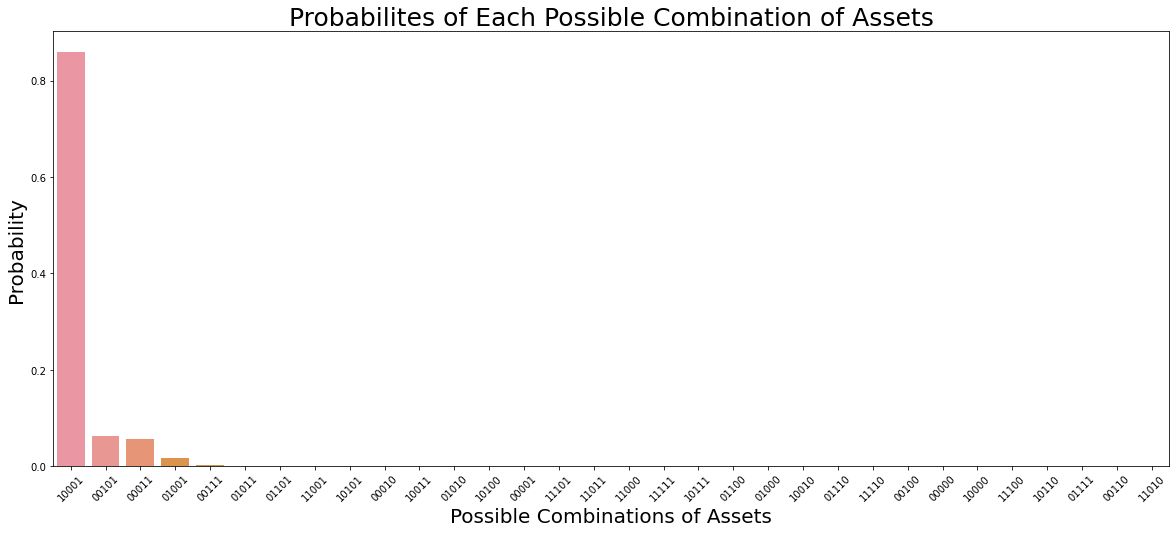

In [28]:
fig, ax = plt.subplots(figsize=(20, 8))
optimized_value = sns.barplot(state, probabilities)
for item in optimized_value.get_xticklabels():
    item.set_rotation(45)
plt.title("Probabilites of Each Possible Combination of Assets", fontsize=25) # Probability of Max Return at given risk level
plt.xlabel('Possible Combinations of Assets',fontsize =20)
plt.ylabel('Probability',fontsize = 20)
plt.show()

### Circuit Design

### Mean-Variance Optimization (cardinality constraint) - Unconstrained - BUY/SELL
$$
\begin{aligned}
& \underset{x}{\text{minimize}} & & \frac{1}{2}x^TQx - r^Tx +  P \cdot (\mathbf{1}^Tx - k)^T \cdot (\mathbf{1}^Tx - k)\\
        &&& x \in \{0,1\}\\
\end{aligned}
$$
#### Corresponding Hamiltonian

### k-medoids clustering for index-tracking
$$
\begin{aligned}
& \underset{x}{\text{minimize}} & & -\alpha \cdot x^TDx + \beta \cdot 1^TDx\\
        &\text{subject to}&& \mathbf{1}^Tx = k\\
        &&& x \in \{0,1\}\\
        &\text{where}&& \alpha = \frac{1}{n-1}, \beta  = \frac{1}{k-1}
\end{aligned}
$$

In [29]:
m = Model("MVO")
x = {}
n = len(Q)
k = 2
beta = 1 / (2 * (k-1))
alpha = 1 / (n-1)
D = df_close_diff.corr()
D = 0.5*(1- D)
D = D.apply(np.sqrt)
D = 1 - (-0.5 * D).apply(np.exp)
D = D.values

x = m.addMVar(shape=n,vtype=GRB.BINARY, name=coins)
obj = -beta * (x @ D @ x) + alpha * (np.ones(n).dot(D) @ x)
m.addConstr(x.sum()==k)
m.setObjective(obj, GRB.MINIMIZE)
m.optimize()

selected = []
for v in m.getVars():
    if v.x == 1:
        selected.append(v.VarName)
print(selected)

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 5 columns and 5 nonzeros
Model fingerprint: 0x7b0fdea1
Model has 10 quadratic objective terms
Variable types: 0 continuous, 5 integer (5 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e-01, 2e-01]
  QObjective range [3e-01, 5e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+00, 2e+00]
Found heuristic solution: objective 0.2193915
Presolve time: 0.00s
Presolved: 11 rows, 15 columns, 35 nonzeros
Variable types: 0 continuous, 15 integer (15 binary)

Root relaxation: objective -4.001084e-01, 4 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   -0.40011    0    5    0.21939   -0.40011   282%     -    0s
H    0     0                       0.